# Simple QNN

<hr>

## Imports

In [143]:
import datetime
import time
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


Equities: `['MSFT', 'DIS', 'HAS', 'JNJ', 'ADBE', 'V']`

dataset structure: `[equity number][train or test][sample number][past or future daily close prices (normalized percentage difference)]`

In [145]:
dataset = np.load('data/dataset.npy', allow_pickle=True)

In [214]:
dis_dataset = dataset[1] # normalized percentage diff close prices of DIS

In [213]:
print(dis_dataset[0][235]) # arbitrary data sample (first array = features or past price data, second array = labels or consecutive price data)

[array([-0.17309885,  0.02608121,  0.01737789,  0.31266864,  0.62879317,
       -0.19485459, -0.54502302, -0.43207662,  0.67312319,  0.05152636,
       -0.47169321, -0.31266864,  0.13138134, -0.84658933, -1.        ]), array([-1.        ,  0.3485534 ,  0.70889132, -0.26760999])]


## QNN Structure

In [144]:
wires = range(15)
n_layers = 3
dev = qml.device('default.qubit', wires=wires)

In [148]:
@qml.qnode(dev, interface="tf")
def qnn(b_seq, gen_weights):
    # Embedding past time series onto circuit
    qml.templates.AngleEmbedding(b_seq, wires, rotation='X')
        
    # Ansatz of choice
    qml.templates.StronglyEntanglingLayers(gen_weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

In [149]:
init_weights = tf.Variable(np.random.uniform(-np.pi, np.pi, (n_layers, len(wires), 3)))

In [150]:
init_weights

<tf.Variable 'Variable:0' shape=(3, 15, 3) dtype=float64, numpy=
array([[[-3.04638246, -2.90255347, -2.20289814],
        [-1.95327889,  1.47919498, -0.7149597 ],
        [ 2.89287985, -2.79650894,  1.33512771],
        [-0.13354587, -1.03641932, -2.54839845],
        [-1.48427838,  0.15471408,  0.81465928],
        [ 1.89485737, -1.41911684, -1.15163592],
        [ 2.69052767,  2.78328966,  1.54263153],
        [-0.77321815,  2.99636022, -2.4074464 ],
        [ 0.07284635,  2.85503142,  1.94183321],
        [ 0.75098423, -2.60100231, -1.72987457],
        [-2.62036917, -3.12371966, -0.96563664],
        [-2.29411486, -2.70329896, -1.43956463],
        [-0.39348817, -1.99171504,  1.17296891],
        [-2.6752982 ,  2.60459119,  1.87543891],
        [ 0.65215318, -2.70198787,  1.98180348]],

       [[-0.92774591, -2.63880338,  2.6922026 ],
        [-1.37652879,  1.39245053,  2.62515032],
        [ 0.24613491, -2.85952006,  0.03859217],
        [-2.27265478,  0.44965653,  2.51797471],
  

In [151]:
qnn(dis_dataset[0][1][0], init_weights)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-0.01329655,  0.00078226, -0.0029407 , -0.00977846])>

In [211]:
mse = tf.keras.losses.MeanSquaredError()
def accuracy(y_true, y_pred):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(y_true, y_pred)
    acc = 1 - m.result().numpy()
    return acc

## One train step

In [188]:
opt = tf.keras.optimizers.Adam(lr=0.0002)

In [189]:
def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as gen_tape: 
        pred_prices = qnn(equity_data[0], gen_weights)
        loss = mse(equity_data[1], pred_prices)
    
    grad = gen_tape.gradient(loss, gen_weights)
    opt.apply_gradients(zip([grad], [gen_weights]))
    
    """Accuracy"""
    acc = accuracy(equity_data[1], qnn(equity_data[0], gen_weights))
    
    return loss, gen_weights, acc

## Training

In [156]:
logdir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/metrics"
file_writer = tf.summary.create_file_writer(logdir)
file_writer.set_as_default()

In [157]:
gloss = []
acc_results = []
acc_results_avg = []

In [196]:
EPOCHS = 6000
batch_size = 2

def train(dataset, epochs, start_epoch=1, new_gen_w=None):    
    for epoch in range(start_epoch, start_epoch + epochs):
        if epoch == 1:
            new_gen_w = tf.Variable(np.ones_like(init_weights.numpy()), dtype="float64")
            new_gen_w.assign(init_weights)
        
        for i, sample in enumerate(dataset[0:batch_size]):
            sample_b = sample[0]
            sample_f = sample[1]
            gl, w, acc = train_step(dataset[i], new_gen_w)
            
            new_gen_w.assign(w)
            acc_results.append(acc)
            gloss.append(gl)

            tf.summary.scalar('Generator Loss', data=gl.numpy(), step=epoch)
            tf.summary.scalar('Prediction Accuracy', data=acc, step=epoch)
        
            if epoch % 10 == 0:
                print(f"Step {i} in {epoch} epoch: Gen loss: {gl} \n             Accuracy: {acc}")
        
        """Average accuracy of QNN"""
        epoch_acc = 0
        for i, sample in enumerate(dataset[0:batch_size]):
            epoch_acc += accuracy(sample[1], qnn(sample[0], new_gen_w))
        epoch_acc = epoch_acc / len(dataset[0:batch_size])
        acc_results_avg.append(epoch_acc)

    return new_gen_w

In [206]:
new_gen_w = train(dis_dataset[0], EPOCHS, start_epoch=1, new_gen_w=new_gen_w) 

Step 0 in 5510 epoch: Gen loss: 0.12081238627433777 
             Accuracy: 0.6578865647315979
Step 1 in 5510 epoch: Gen loss: 0.13840650022029877 
             Accuracy: 0.718648374080658
Step 0 in 5520 epoch: Gen loss: 0.12052378803491592 
             Accuracy: 0.658231109380722
Step 1 in 5520 epoch: Gen loss: 0.1380031853914261 
             Accuracy: 0.7189469337463379
Step 0 in 5530 epoch: Gen loss: 0.12023841589689255 
             Accuracy: 0.6585724353790283
Step 1 in 5530 epoch: Gen loss: 0.13759994506835938 
             Accuracy: 0.7192458510398865
Step 0 in 5540 epoch: Gen loss: 0.11995623260736465 
             Accuracy: 0.6589105129241943
Step 1 in 5540 epoch: Gen loss: 0.13719676434993744 
             Accuracy: 0.7195451855659485
Step 0 in 5550 epoch: Gen loss: 0.11967720091342926 
             Accuracy: 0.6592453718185425
Step 1 in 5550 epoch: Gen loss: 0.13679362833499908 
             Accuracy: 0.7198449671268463
Step 0 in 5560 epoch: Gen loss: 0.11940126866102219 


## Training metrics

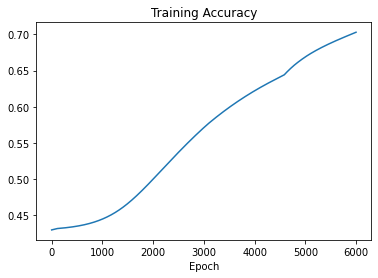

In [207]:
plt.plot(range(len(acc_results_avg)), acc_results_avg)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

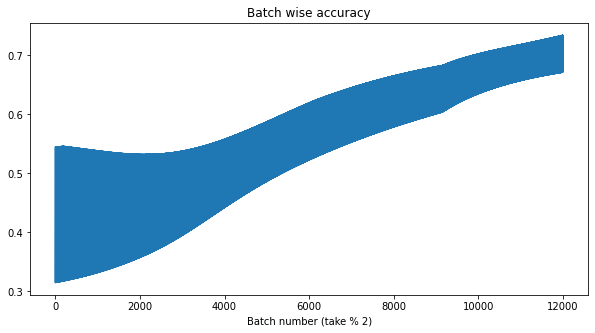

In [208]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_results)), acc_results)
plt.title("Batch wise accuracy")
plt.xlabel(f"Batch number (take % {batch_size})")
plt.show()

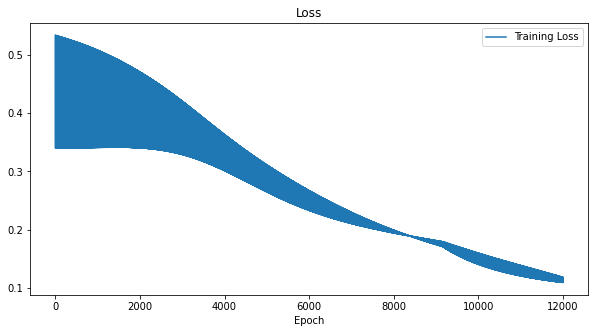

In [209]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(gloss)), gloss, label="Training Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Results compared

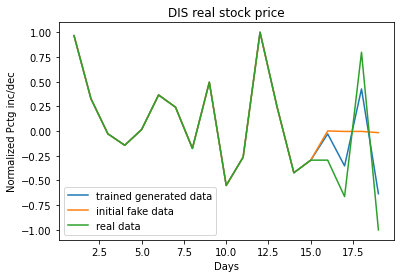

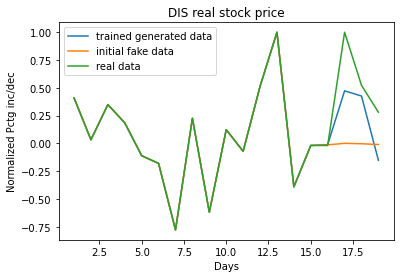

In [210]:
for i in range(batch_size):
    days =  np.arange(1, len(dis_dataset[0][0][0]) + len(dis_dataset[0][0][1]) + 1)
    real_stats = np.append(dis_dataset[0][i][0], dis_dataset[0][i][1])
    fake_stats = tf.concat([dis_dataset[0][i][0], qnn(dis_dataset[0][i][0], new_gen_w)], 0).numpy()
    init_fake_stats = tf.concat([dis_dataset[0][i][0], qnn(dis_dataset[0][i][0], init_weights)], 0).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, init_fake_stats, label="initial fake data")
    plt.plot(days, real_stats, label="real data")
    plt.title("DIS real stock price")
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg inc/dec")
    plt.legend()
    plt.show()